# COVID-19 Forecasting

**Import Libraries**

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
plt.style.use("fivethirtyeight")
import tensorflow_probability as tfp
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from IPython.display import display, HTML
tfd = tfp.distributions

**Import dataset**

In [2]:
df = pd.read_csv("data/covid19.csv", dtype = {
    "Country/Region": str, "Province/State": str, "Latitude": float, "Longitude": float, 
    "Confirmed": float, "Recovered": float, "Deaths": float, "Date": str})
df["Confirmed"].fillna(0, inplace = True)
df["Deaths"].fillna(0, inplace = True)
df["Recovered"].fillna(0, inplace = True)

**Plot actual epicurves**

In [3]:
def plot_country_epicurves(df, country):
    df = df.copy()
    df.Date = pd.to_datetime(df.Date, format = "%Y-%m-%d") 
    df = df.set_index("Date")  
    data = df[df["Country/Region"] ==  country]
    #Sum sub regions daily counts
    data = data.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
    plt.figure(figsize = (12, 5))
    plt.plot(data.Date, data.Confirmed, label = "Confirmed")
    plt.plot(data.Date, data.Recovered, label = "Recovered")
    plt.plot(data.Date, data.Deaths, label = "Deaths")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend(frameon = True, fontsize = 12)
    plt.title(country + " COVID-19 cases", fontsize = 35)
    plt.tight_layout()
    plt.savefig(country + " actual.png")
    plt.show()

/Users/mirfan/PycharmProjects/urdunlp/.urdunlp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


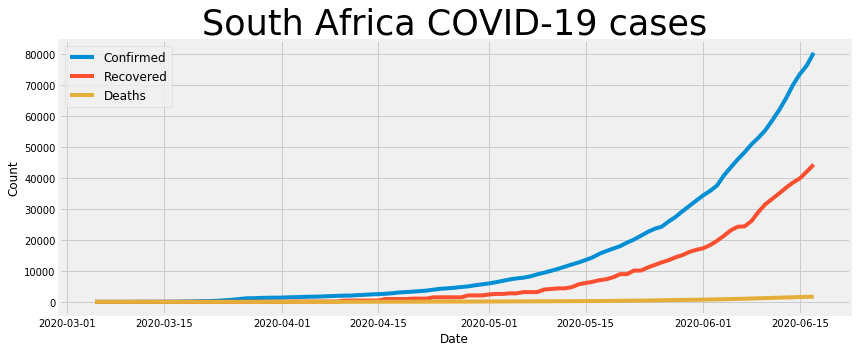

In [4]:
plot_country_epicurves(df, "South Africa")

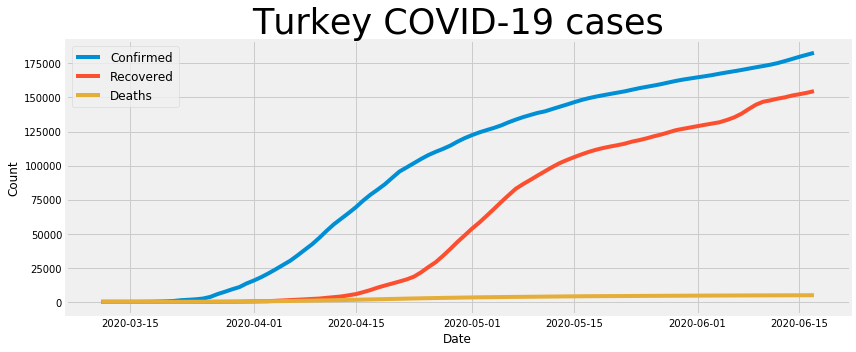

In [5]:
plot_country_epicurves(df, "Turkey")

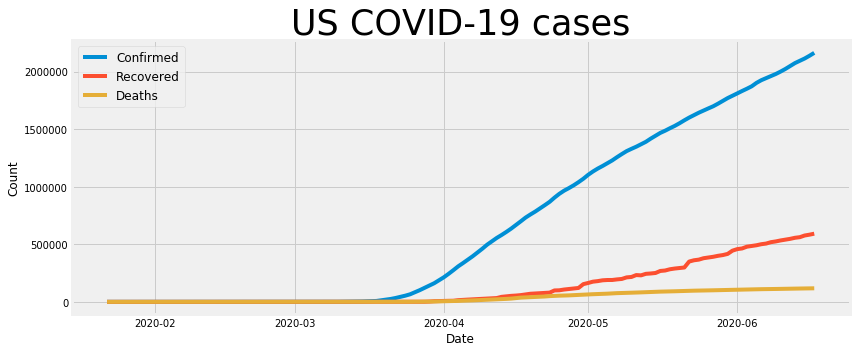

In [6]:
plot_country_epicurves(df, "US")

**Forecast functions**

In [7]:
"""
Analytic functions

"""
def r2(actual, predict):
    """Coefficient of determination percentage"""
    return r2_score(actual, predict) * 100
    
def smape(actual, predict):
    """Symmetric mean absolute percentage error"""
    return (100 / len(actual.values)) *\
        ((np.sum(np.abs(predict.values - actual.values) / 
         (np.abs(actual.values) + np.abs(predict.values)) / 2)))

def mae(actual, predict):
    """Mean absolute error"""
    return mean_absolute_error(actual, predict)
    
def analyze_forecast(train_values, test_values, predict_values):
    """Display a table of measurements"""
    df_table = pd.DataFrame()
    df_table["R-Squared"]      = [r2(test_values, predict_values)]
    df_table["sMAPE"]          = [smape(test_values, predict_values)]
    df_table["MAE"]            = [mae(test_values, predict_values)]
    display(HTML(df_table.to_html(index = False)))     

In [8]:
def plot_forecast(data, train, forecasts, feature, country, save_figure):
    plt.figure(figsize = (12, 5))
    data.index = pd.to_datetime(data.index)
    train.index = pd.to_datetime(train.index)
    forecasts.index = pd.to_datetime(forecasts.index)
    plt.plot(data, label = "Observed data")
    plt.plot(train, label = "Train data")
    plt.plot(forecasts, label = "Forecast data")
    plt.legend(loc = "best")
    plt.xticks(rotation = 50)
    plt.title(country + " - " + feature + " cases", fontsize = 30)
    if save_figure:
        plt.tight_layout()
        plt.savefig(country + "_lstm_forecasts.png")
    plt.show()

In [9]:
def split_featured_data(df, feature, country, train_start, train_end):  
    df = df.copy()
    data = df[df["Country/Region"] == country]   
    #Sum sub regions daily counts
    data = data.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
    data = data[["Date", feature]]
    data = data.set_index("Date")
    #remove 0 values - made large plots
    data = data[data[feature] != 0]
    smooved_data = data.rolling(2, min_periods = 1).mean()
    #find indices of training data
    train_start = np.where(data.index.to_numpy() == train_start)[0][0]  
    train_end = np.where(data.index.to_numpy() == train_end)[0][0] 
    train = smooved_data[train_start:train_end]
    test = data[train_end:len(data)]
    return data, train, test

In [10]:
"""
Performs forecasting using a Bayes Neural Network

Parameters
----------
df : DataFrame
    The Pandas DataFrame loaded from csv
feature : str
    Feature from the DataFrame to forecast
country : str
    Country from the DataFrame to forecast
train_start : str
    String date to start training dataset
train_end : str
    String date to end training dataset
plot : bool
    Plotting of curves enabled
future_count : int 
    Number of days to forecast beyond the df's last date
save_figure : bool
    Save the forecast plot to image file
    
"""
def bnn(df, feature, country, train_start, train_end, plot = True, future_count = 0, plot_bnn_model = False, save_figure = False):
    #Split data 
    data, train, test = split_featured_data(df, feature, country, train_start, train_end)
    #Scale data
    scaler = MinMaxScaler().fit(data)
    train_scaled = scaler.transform(train.values)
    test_scaled = scaler.transform(test.values)
    # Define prior for regularization.prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)# Define model instance.model = tfk.Sequential([
    # Load libriaries and functions.import pandas as pd
    n_observations = 8


    # Compile model.model.compile(optimizer="adam", loss=neg_log_likelihood)# Run training session.model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)# Describe model.model.summary()
    # BNN model:
    # Only change this section
    # ...
    kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(len(train), dtype=tf.float32))
    model = tf.keras.models.Sequential()
    model.add(tfp.layers.Convolution2DFlipout(192, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu))
    model.add(tfp.layers.Convolution2DFlipout(384, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu))
    model.add(tfp.layers.Convolution2DFlipout(384, kernel_divergence_fn=kl_divergence_function,activation=tf.nn.relu))

    model.add(tf.keras.layers.Flatten())
    model.add(tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function,activation=tf.nn.softmax))
    model.compile(optimizer = Adam(lr=0.00001), loss = "mae")

    generator = TimeseriesGenerator(train_scaled, train_scaled, length = n_observations, batch_size = 4)
    model.fit(generator, verbose = 0, epochs = 110)
    #Predictions
    forecasts = []
    batch = (train_scaled[-n_observations:]).reshape((1, n_observations, 1))
    for entry in range(len(test)):
        forecast = model.predict(batch)[0]
        forecasts.append(forecast)
        batch = np.append(batch[:,1:,:],[[forecast]], axis = 1)
    forecasts = pd.DataFrame(scaler.inverse_transform(forecasts), columns = [feature])
    #Create forecasted dates
    forecast_start = datetime.datetime.strptime(train_end_date, "%Y-%m-%d")
    forecast_dates = [(forecast_start - datetime.timedelta(days = -x)).date().strftime("%Y-%m-%d")
                      for x in range(len(test) + future_count)]
    forecasts["Date"] = forecast_dates
    forecasts = forecasts.set_index("Date")
    if plot:
        plot_forecast(data, train, forecasts, feature, country, save_figure)
    if future_count == 0:
        analyze_forecast(train.values, test, forecasts)
    if plot_bnn_model:
        print(model.summary())
        return plot_model(model, to_file="bnn_model.png", show_shapes = True, show_layer_names = True)

In [11]:
"""
Performs forecasting using an LSTM recurrent neural network

Parameters
----------
df : DataFrame
    The Pandas DataFrame loaded from csv
feature : str
    Feature from the DataFrame to forecast
country : str
    Country from the DataFrame to forecast
train_start : str
    String date to start training dataset
train_end : str
    String date to end training dataset
plot : bool
    Plotting of curves enabled
future_count : int 
    Number of days to forecast beyond the df's last date
plot_lstm_model : bool 
    Plot an image of the Keras model instance
save_figure : bool
    Save the forecast plot to image file
    
"""
def lstm(df, feature, country, train_start, train_end, plot = True, future_count = 0, plot_lstm_model = False, save_figure = False):  
    #Split data 
    data, train, test = split_featured_data(df, feature, country, train_start, train_end)
    #Scale data
    scaler = MinMaxScaler().fit(data)
    train_scaled = scaler.transform(train.values)
    test_scaled = scaler.transform(test.values)
    #LSTM model
    n_observations = 8
    model = Sequential()
    model.add(Input(shape = (n_observations, 1)))
    model.add(LSTM(units = 192, return_sequences = True, activation = "tanh", recurrent_activation = "sigmoid"))
    model.add(LSTM(units = 384, return_sequences = True, activation = "tanh", recurrent_activation = "sigmoid"))
    model.add(LSTM(units = 384, activation = "tanh", recurrent_activation = "sigmoid"))
    model.add(Dense(units = 1, activation = None))
    model.compile(optimizer = Adam(lr=0.00001), loss = "mae") 
    generator = TimeseriesGenerator(train_scaled, train_scaled, length = n_observations, batch_size = 4) 
    model.fit(generator, verbose = 0, epochs = 110) 
    #Predictions
    forecasts = []
    batch = (train_scaled[-n_observations:]).reshape((1, n_observations, 1))
    for entry in range(len(test)): 
        forecast = model.predict(batch)[0]
        forecasts.append(forecast) 
        batch = np.append(batch[:,1:,:],[[forecast]], axis = 1)
    forecasts = pd.DataFrame(scaler.inverse_transform(forecasts), columns = [feature])  
    #Create forecasted dates
    forecast_start = datetime.datetime.strptime(train_end_date, "%Y-%m-%d")
    forecast_dates = [(forecast_start - datetime.timedelta(days = -x)).date().strftime("%Y-%m-%d") 
                      for x in range(len(test) + future_count)]
    forecasts["Date"] = forecast_dates
    forecasts = forecasts.set_index("Date")   
    if plot:
        plot_forecast(data, train, forecasts, feature, country, save_figure)
    if future_count == 0:
        analyze_forecast(train.values, test, forecasts)
    if plot_lstm_model:
        print(model.summary())
        return plot_model(model, to_file="lstm_model.png", show_shapes = True, show_layer_names = True)

**Training data dates**
<br>Forecasts are complete from training end date to last date in df 

In [12]:
train_start_date = "2020-05-01"
train_end_date = "2020-06-01"

## South Africa LSTM Forecasts

  ...
    to  
  ['...']


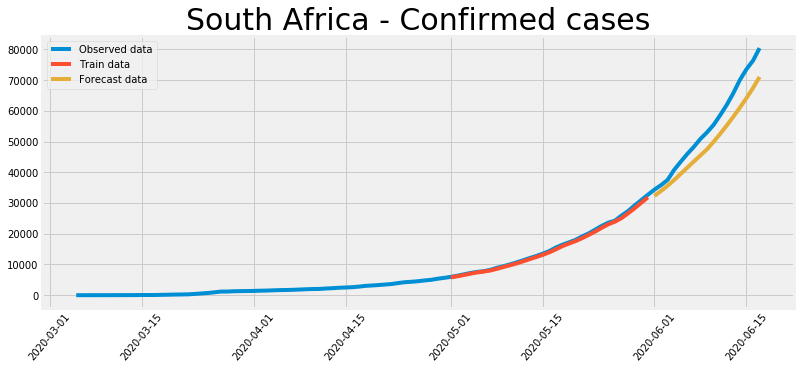

R-Squared,sMAPE,MAE
81.13021,2.569093,5635.079521


In [13]:
lstm(df, "Confirmed", "South Africa", train_start_date, train_end_date)

  ...
    to  
  ['...']


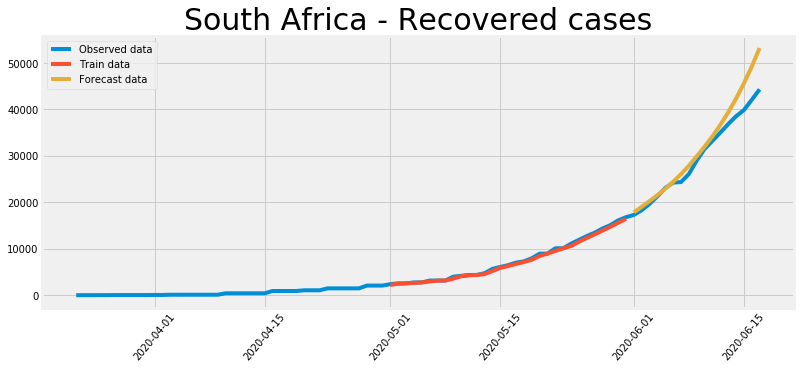

R-Squared,sMAPE,MAE
83.829205,1.49109,2239.269924


In [14]:
lstm(df, "Recovered", "South Africa", train_start_date, train_end_date)

  ...
    to  
  ['...']


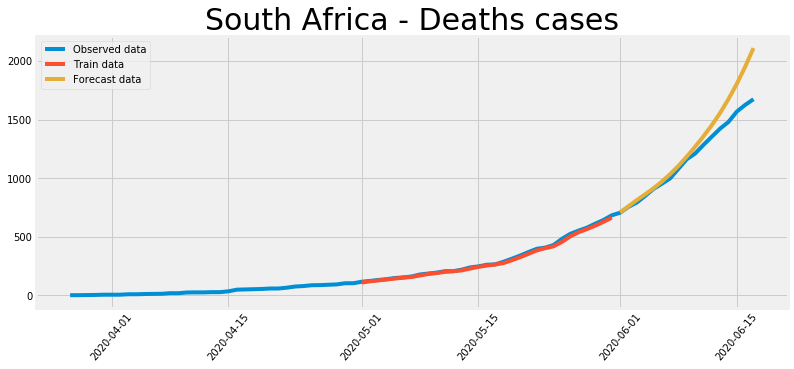

R-Squared,sMAPE,MAE
73.39851,1.605125,100.259322


In [15]:
lstm(df, "Deaths", "South Africa", train_start_date, train_end_date)

## Turkey LSTM Forecasts

  ...
    to  
  ['...']


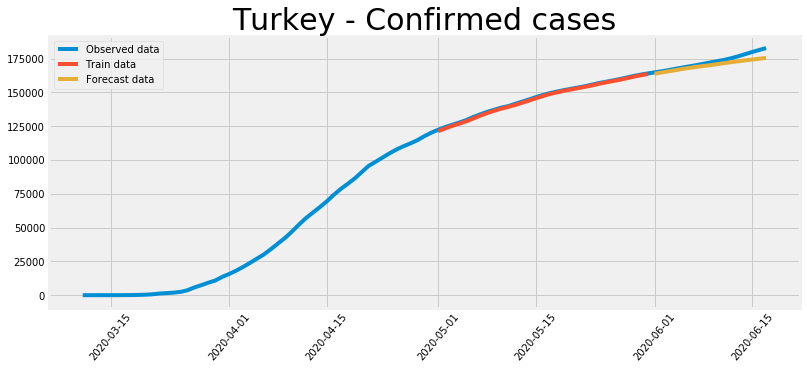

R-Squared,sMAPE,MAE
61.488599,0.387828,2705.10535


In [16]:
lstm(df, "Confirmed", "Turkey", train_start_date, train_end_date)

  ...
    to  
  ['...']


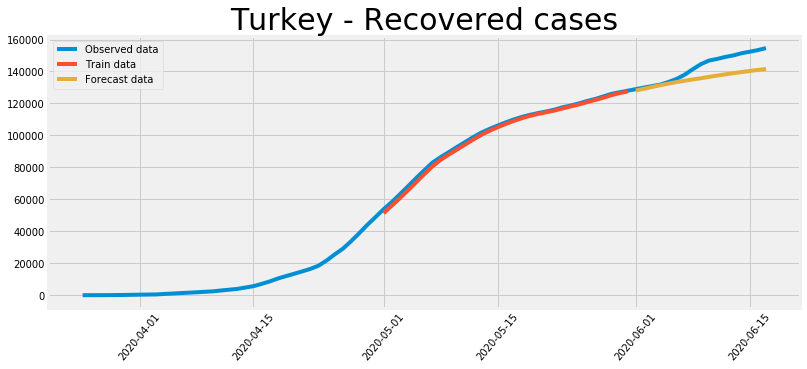

R-Squared,sMAPE,MAE
10.574757,1.193078,6841.300739


In [17]:
lstm(df, "Recovered", "Turkey", train_start_date, train_end_date)

  ...
    to  
  ['...']


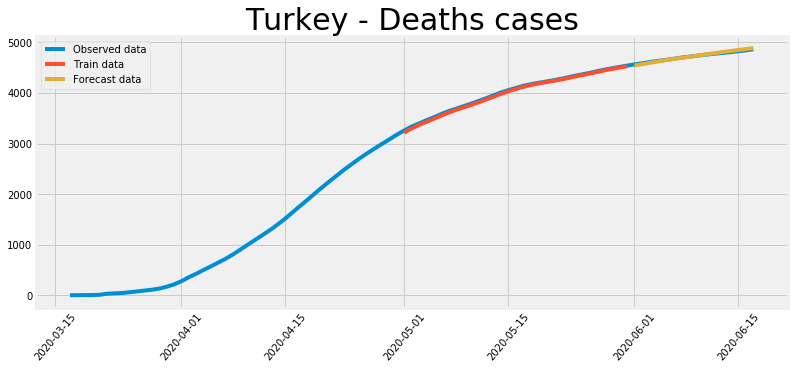

R-Squared,sMAPE,MAE
96.850751,0.070851,13.437391


In [18]:
lstm(df, "Deaths", "Turkey", train_start_date, train_end_date)

## USA LSTM Forecasts

  ...
    to  
  ['...']


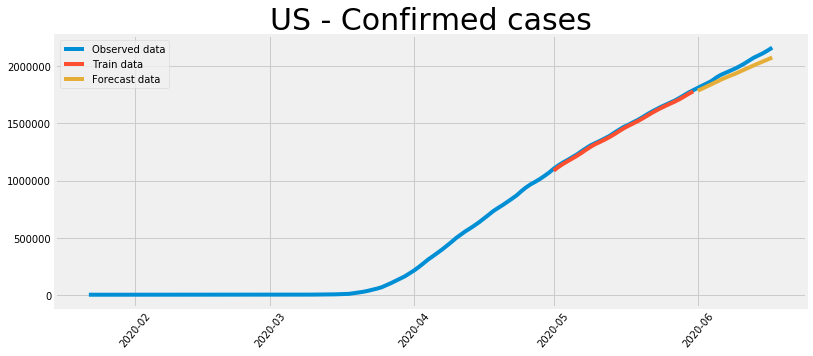

R-Squared,sMAPE,MAE
74.945005,0.62962,50137.729964


In [19]:
lstm(df, "Confirmed", "US", train_start_date, train_end_date)

  ...
    to  
  ['...']


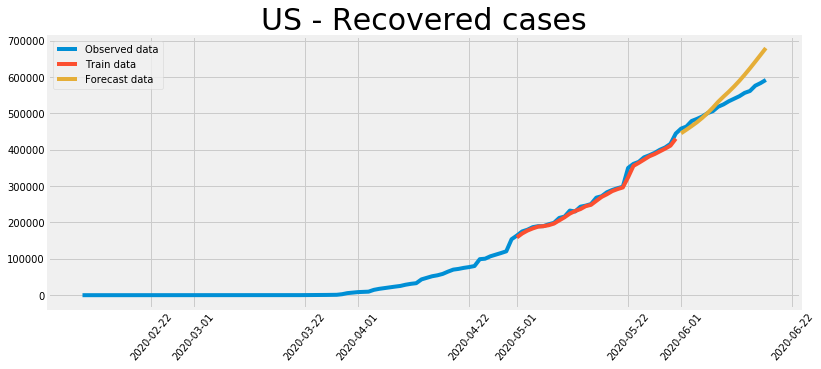

R-Squared,sMAPE,MAE
-5.83943,1.371374,31681.354047


In [20]:
lstm(df, "Recovered", "US", train_start_date, train_end_date)

  ...
    to  
  ['...']


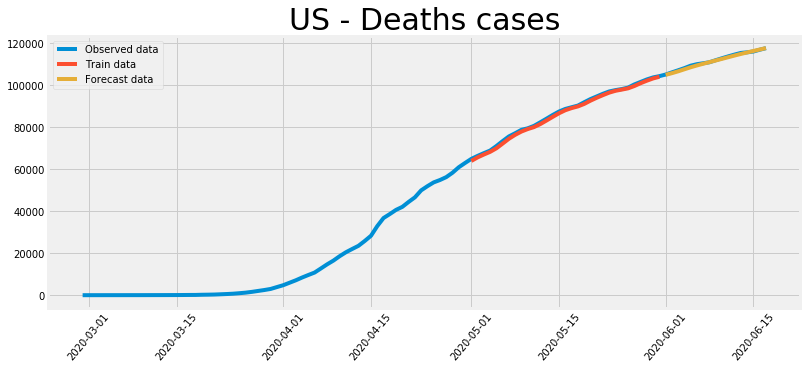

R-Squared,sMAPE,MAE
98.992409,0.071403,316.169422


In [21]:
lstm(df, "Deaths", "US", train_start_date, train_end_date)

## South Africa BNN Forecasts

In [22]:
bnn(df, "Confirmed", "South Africa", train_start_date, train_end_date)

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [ ]:
bnn(df, "Deaths", "South Africa", train_start_date, train_end_date)

In [ ]:
bnn(df, "Recovered", "South Africa", train_start_date, train_end_date)

## Turkey BNN Forecasts

In [ ]:
bnn(df, "Confirmed", "Turkey", train_start_date, train_end_date)

In [ ]:
bnn(df, "Deaths", "Turkey", train_start_date, train_end_date)

In [ ]:
bnn(df, "Recovered", "Turkey", train_start_date, train_end_date)

## US BNN Forecasts

In [ ]:
bnn(df, "Confirmed", "US", train_start_date, train_end_date)

In [ ]:
bnn(df, "Deaths", "Turkey", train_start_date, train_end_date)

In [ ]:
bnn(df, "Recovered", "Turkey", train_start_date, train_end_date)